# RespiCoV sequencing analysis by primer

Analyze fastq file(s) from nanopore sequencing output using [RespiCoV](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264855) primers. Designed for ligation sequencting chemistry.

Run here on my first RespiCoV sequencing attempt where I knew (from gel) that I had a lot of mis-priming, and where my flow cell was nearly exhausted. 

**Goals:**
 * Identify likely target matches per input sample, for downstream sequence alignment
 * Quantify PCR effectiveness and visualize the ways in which PCR mis-priming occurs in practice.
 * Run quickly on a single machine and scale linearly with input sequence
 * Enable iterative exploration of the data (cache the most expensive operations)

**TODO:**
 * Generate histogram of how much of each read is occuppied by primer sequence
 * Generate summary stastics total and per subdir:
   * Total number of reads
   * Fraction of reads which contribute to likely primer pair
   * Fraction of sequence data matching primers
   * Fraction of sequence data covering likely primer pair spans
 
**Non-goals / future work elsewhere:**
 * Virus type-analysis for matches
 * Integrate Kraken / minimap2 analysis to suggest likely source of mis-priming. In particular, human matches
 * Map reads to target genome sequences
 * Attempt to separate reads from distinct genomes pooled into the same barcode (eg. by type)
 * Use reads which only include one (or even zero) primers, eg. for tagmentation chemistry

## Initialization and configuration

In [1]:
from Bio.Seq import Seq
from Bio import SeqIO
import os
import gzip
import pandas as pd
import RCUtils

fastQBaseDir = "../20221204_2344_MN41817_FAV39017_1bf37150/fastq_pass/"

pd.options.display.max_rows = 50
pd.options.display.min_rows = 25

primers = RCUtils.readPrimers("RespiCovPrimers.fasta")
print("Read %i primers" % (len(primers)))

# Store primer indicies for efficient serialization
for i, primer in enumerate(primers):
    primer.index = i
    primer.baseName = primer.description[:primer.description.rindex(' ')]

Read 114 primers


## Compute and save primer matches if needed
Includes all the functions for getting reads and hits

In [2]:
from IPython.display import clear_output 
from Bio import Align
import time
import json

def serializeHit(hit):
    return [hit.primer.index, hit.start, hit.end, hit.rev, hit.mr]

def deserializeHit(hitBuf):
    return RCUtils.Hit(primer=primers[hitBuf[0]], start=hitBuf[1], end=hitBuf[2], rev=hitBuf[3], mr=hitBuf[4])

def getFastQAndHitsFiles(subdir):
    fastQDir = os.path.join(fastQBaseDir, subdir)
    for file in sorted(filter(lambda f: f.endswith(".fastq.gz"), os.listdir(fastQDir))):
        fastQPath = os.path.join(fastQDir, file)
        yield (fastQPath, fastQPath.removesuffix(".fastq.gz")+"-hits.json")

# Get reads from a gzipped fastQ file
def readFastQ(path):
    with gzip.open(path, "rt") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            yield record

# Find primer matches and save them to files if files don't already exist
def generateHitsFile(subdir, overwrite=False):
    for (fastQPath, hitsPath) in getFastQAndHitsFiles(subdir):
        if overwrite or not os.path.exists(hitsPath):
            print("Processing ", os.path.basename(fastQPath), end="")
            reads = 0
            start = time.process_time()
            serializedHitsPerRead = []
            for read in readFastQ(fastQPath):
                reads += 1
                if reads % 100 == 0:
                    print(".",end="")
                hits = RCUtils.computePrimerHits(read, primers)
                serializedHitsPerRead.append([serializeHit(hit) for hit in hits])

            elapsed = time.process_time() - start
            print("  %.2fs" % elapsed)

            with open(hitsPath, "w") as f:
                json.dump(serializedHitsPerRead, f)
        else:
            print("Found ", os.path.basename(hitsPath))

def getAllFastQDirs():
    for dir in sorted(os.listdir(fastQBaseDir)):
        if dir.startswith("barcode"):
            yield dir

# Return all raw reads in a sub-directory on their own
def getReads(subdir):
    for (fastQPath,_) in getFastQAndHitsFiles(subdir):
        for read in readFastQ(fastQPath):
            yield read

def getAllReads():
    for subdir in getAllFastQDirs():
        for read in getReads(subdir):
            yield read

# Stream all reads for a given subdirectory, along with the pre-computed primer matches
def getPrimerMatches(subdir):
    for (fastQPath,hitsPath) in getFastQAndHitsFiles(subdir):
        with open(hitsPath, "r") as hitsFile:
            serializedHitsPerRead = json.load(hitsFile)
            
        for (readIdx,read) in enumerate(readFastQ(fastQPath)):
            hits = []
            for hitBuf in serializedHitsPerRead[readIdx]:
                hit = deserializeHit(hitBuf)
                assert hit.start < len(read.seq)
                assert hit.end <= len(read.seq)
                hits.append(hit)
            yield (read, hits)
                
def getAllPrimerMatches():
    for subdir in getAllFastQDirs():
        for (r,h) in getPrimerMatches(subdir):
            yield (subdir, r, h)

# Actually generate all the hits files
for subdir in getAllFastQDirs():
    generateHitsFile(subdir)

Processing  FAV39017_pass_barcode01_1d0a44b7_0.fastq.gz......  1.61s
Processing  FAV39017_pass_barcode02_1d0a44b7_0.fastq.gz......  1.53s
Processing  FAV39017_pass_barcode03_1d0a44b7_0.fastq.gz....  1.04s
Processing  FAV39017_pass_barcode04_1d0a44b7_0.fastq.gz......  1.37s
Processing  FAV39017_pass_barcode05_1d0a44b7_0.fastq.gz......  1.52s
Processing  FAV39017_pass_barcode06_1d0a44b7_0.fastq.gz.......  1.73s
Processing  FAV39017_pass_barcode07_1d0a44b7_0.fastq.gz........  1.81s
Processing  FAV39017_pass_barcode08_1d0a44b7_0.fastq.gz........  1.81s


## How many primers are found in each read?
Notable here is that, in my first experiment nearly every read included at least one primer, suggesting PCR products did dominate the results. 
Proper amplification and sequencing should typically result in 2 primers per read, which is indeed the most common result. But it's also very common to have only a single primer.
It's also not unusual to have several primers, suggesting primer-dimers.

In [3]:
from collections import Counter

readsPerPrimerCount = Counter()
readTotal = 0
for (subdir, read, hits) in getAllPrimerMatches():
    readTotal += 1
    readsPerPrimerCount[len(hits)] += 1

table = pd.DataFrame.from_dict(readsPerPrimerCount, orient="index", columns=["Reads"])
table.index.name = "Primer Count"
table.sort_index(inplace=True)
table["%"] = table["Reads"].apply(lambda r: round(r / readTotal * 100, ndigits=2))
table

,Reads,%
Primer Count,,
0,214,3.85
1,1297,23.35
2,3245,58.42
3,486,8.75
4,253,4.55
5,33,0.59
6,18,0.32
7,9,0.16


## What is the distribution of primer match scores
Most hits exactly match a primer, but small numbers of mismatches are not uncommon.
In earlier testing, match scores of around 60% and lower were extremely common, purely by chance.

4372 of 10593 (41%) of primer hits are a perfect match


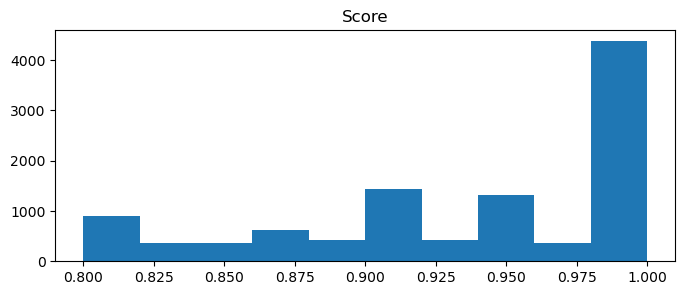

In [4]:
mrs = []
perfect = 0
for (subdir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        mrs.append(hit.mr)
        if hit.mr == 1.0:
            perfect += 1

print("%d of %d (%d%%) of primer hits are a perfect match" % (perfect, len(mrs), 100*perfect/len(mrs)))
pd.DataFrame({'Score': mrs}).hist(figsize=(8,3), bins=10, grid=False);

## How often is each primer seen?
With a highly-specific PCR reaction I would expect to see the primer matches dominated by the legitimate target sequences. That's not the case here, suggesting perhaps the annealing temp was too low. More analysis is clearly needed in order to identify likely targets in the data.

In [5]:
hitsPerPrimer = dict()
for p in primers:
    hitsPerPrimer[p.description] = [0,0,0]

hitsTotal = 0
for (subdir, record, hits) in getAllPrimerMatches():
    hitsTotal += len(hits)
    for hit in hits:
        hitsPerPrimer[hit.primer.description][1 if hit.rev else 0] += 1
        hitsPerPrimer[hit.primer.description][2] += hit.mr

def addPercent (entry):
    (primer, [fwd,rev,mrtot]) = entry
    return (primer, fwd, rev, round((fwd+rev) / hitsTotal * 100, ndigits=2), round(mrtot / (fwd+rev), ndigits=2))

data = map(addPercent, filter(lambda p:p[1]!=[0,0,0], hitsPerPrimer.items()))
table = pd.DataFrame(data, columns=["Primer","Fwd hits", "Rev hits", "%", "Avg MR"])
table.set_index("Primer", inplace=True)
table.sort_values("%", ascending=False, inplace=True)
table

,Fwd hits,Rev hits,%,Avg MR
Primer,,,,
Influenza A virus 2,125,131,2.42,0.96
SARS coronavirus 1/2 3,130,115,2.31,0.94
Chlamydophila pneumoniae 2,128,117,2.31,0.95
Mycoplasma pneumoniae 1,139,101,2.27,0.95
Hendra virus 5,131,108,2.26,0.94
Hantaan virus 3,95,134,2.16,0.95
Streptococcus pneumoniae 2,110,104,2.02,0.95
Human parechovirus 1,86,109,1.84,0.96
Mycoplasma pneumoniae 2,98,94,1.81,0.92


## Which primers are never seen exactly?
If a primer is never seen at all, that may suggest a failure in the assay preparation
or synthesis. 

In [6]:
primerMaxMatch = dict.fromkeys(map(lambda p:p.description, primers), 0.0)

for (subdir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        if primerMaxMatch[hit.primer.description] < hit.mr:
            primerMaxMatch[hit.primer.description] = hit.mr

table = pd.DataFrame.from_dict(primerMaxMatch, orient="index", columns=["Max Match"])
table.index.name = "Primer"
table.sort_values("Max Match", ascending=False, inplace=True)
table[table["Max Match"] < 1.0]

,Max Match
Primer,
Influenza A virus 20,0.96
Influenza A virus 22,0.96
Influenza B virus 5,0.87
Human respiratory syncytial virus 1.0,0.81
Human respiratory syncytial virus 1.1,0.00


## What's the distribution of read lengths and primer positions?

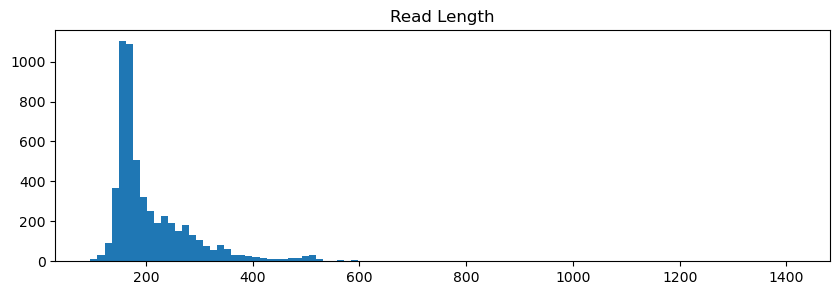

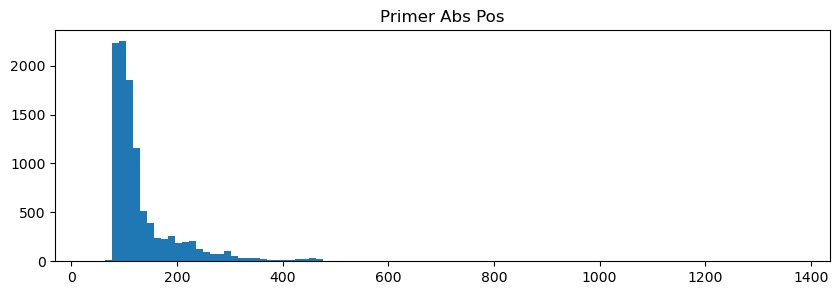

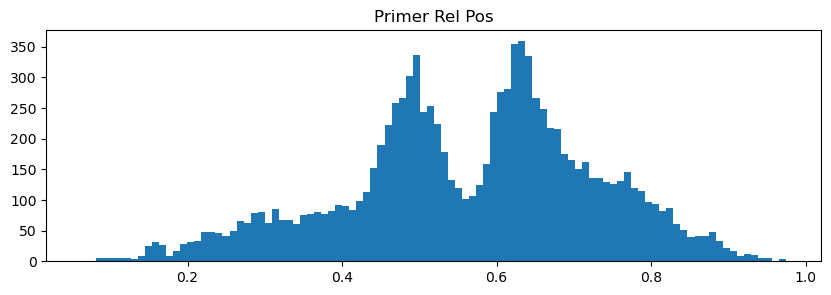

In [7]:
lengths=[]
paPos=[]
prPos=[]

for (subdir, read, hits) in getAllPrimerMatches():
    lengths.append(len(read.seq))
    paPos += map(lambda hit: hit.end, hits)
    prPos += map(lambda hit: (hit.start+hit.end)/2/len(read.seq), hits)

pd.DataFrame({'Read Length': lengths}).hist(bins=100, figsize=(10,3), grid=False)
pd.DataFrame({'Primer Abs Pos': paPos}).hist(bins=100, figsize=(10,3), grid=False)
pd.DataFrame({'Primer Rel Pos': prPos}).hist(bins=100, figsize=(10,3), grid=False);

The relative position of primer hits in the reads creates a strange bimodal pattern around the middle. I'm not sure what to make of this.

## What is the distance between primer hits?
When there is more than one primer hit in a read, most of the time they are separate by no more than 20bp, and most commonly they are immediately adjacent (primer-dimers).

Human adenovirus 7
target          268 GGGGCTCAGGTACTCCGA 286
                  0 ||||||||||||||||||  18
query             0 GGGGCTCAGGTACTCCGA  18

Human coronavirus 229E 1
target          286 TAGAA-GGGCAAACGGGTGG 305
                  0 |||||-||||||||||||||  20
query             0 TAGAAAGGGCAAACGGGTGG  20

71% <20bp


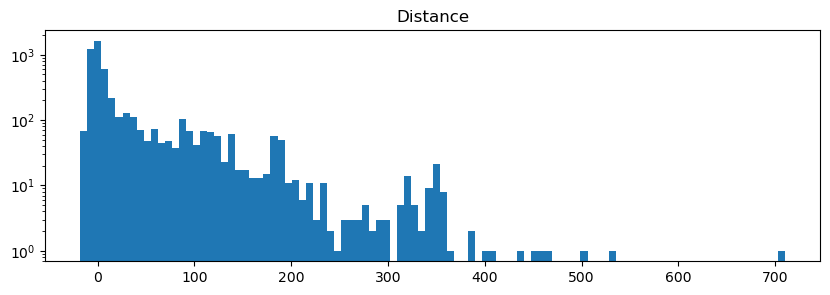

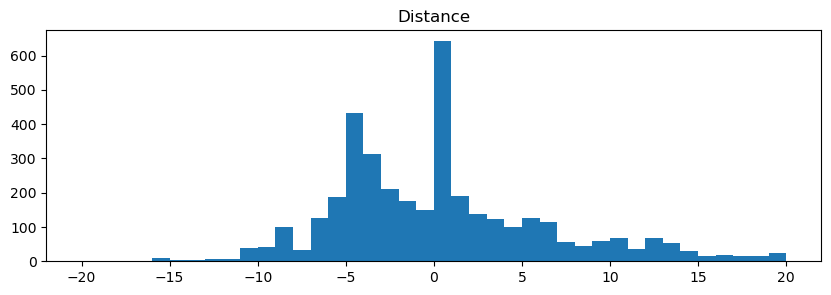

In [8]:
import matplotlib.pyplot as plt 

# Find the hits with the maximum overlap (below our threshold)
dists = []
countShort = 0
countTotal = 0
adjhit = None
for (subdir, read, hits) in getAllPrimerMatches():
    hits.sort(key=lambda h: h.start)
    for i in range(len(hits)-1):
        countTotal += 1
        dist = hits[i+1].start - hits[i].end
        if dist < 20:
            countShort += 1
        dists.append(dist)
        if dist == 0 and adjhit == None:
            adjhit = (read, hits[i], hits[i+1])

aligner = Align.PairwiseAligner(mode='local', match_score=1, mismatch_score=0, gap_score=-1)
print(adjhit[1].primer.description)
print(aligner.align(adjhit[0].seq, adjhit[1].primer.rcSeq if adjhit[1].rev else adjhit[1].primer.seq)[0])
print(adjhit[2].primer.description)
print(aligner.align(adjhit[0].seq, adjhit[2].primer.rcSeq if adjhit[2].rev else adjhit[2].primer.seq)[0])

print("%d%% <20bp" % int(100*countShort/countTotal))
df = pd.DataFrame({'Distance': dists})
df.hist(bins=100, grid=False, log=True, figsize=(10,3))
df.hist(bins=40, grid=False, range=(-20,20), figsize=(10,3));

## How much do primers overlap below our threshold?

Max overlap score: 0.78, read 35e315b6-3dc9-4f51-9974-0be98e9e45d5
Influenza B virus 5 mr=0.80
target           81 AAATTATTCAAGGCATGTAAAATGAAGAA 110
                  0 |||||||||||.|||.||||||..|.|||  29
query             0 AAATTATTCAATGCAAGTAAAACTAGGAA  29

Human coronavirus NL63 1 mr=0.96
target           92 GGCATGTAAAATGAAGAAGGAGG 115
                  0 ||||||||||||||||.||||||  23
query             0 GGCATGTAAAATGAAGGAGGAGG  23



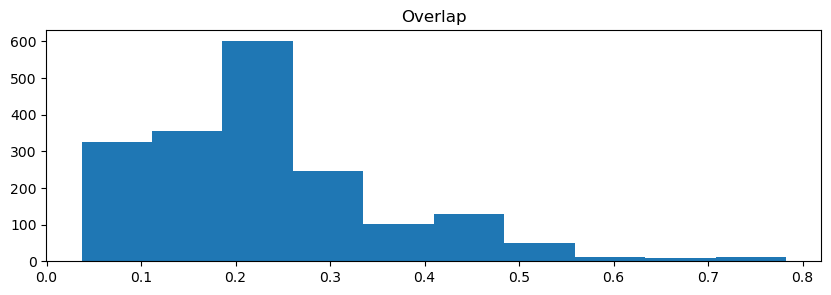

In [9]:
# Find the hits with the maximum overlap (below our threshold)
overlaps = []
maxo = 0
maxhit = None
for (subdir, read, hits) in getAllPrimerMatches():
    for i in range(len(hits)):
        for j in range(i):
            o = RCUtils.computeOverlap(hits[i],hits[j])
            if o > 0:
                overlaps.append(o)
                if o > maxo:
                    maxo = o
                    maxhit = (read, hits[i], hits[j])

print("Max overlap score: %.2f, read %s" % (maxo, maxhit[0].id))
print("%s mr=%.2f" % (maxhit[1].primer.description,maxhit[1].mr))
print(aligner.align(maxhit[0].seq, maxhit[1].primer.rcSeq if maxhit[1].rev else maxhit[1].primer.seq)[0])
print("%s mr=%.2f" % (maxhit[2].primer.description,maxhit[2].mr))
print(aligner.align(maxhit[0].seq, maxhit[2].primer.rcSeq if maxhit[2].rev else maxhit[2].primer.seq)[0])
      
pd.DataFrame({'Overlap': overlaps}).hist(figsize=(10,3), grid=False);


# Find possible primer pairs

In [10]:
def getPrimerPairs(subdir=None):
    if subdir:
        gen = ((subdir, read, hits) for (read, hits) in getPrimerMatches(subdir))
    else:
        gen = getAllPrimerMatches()
    for (subdir, read, hits) in gen:
        for hit1 in hits:
            if not hit1.rev:
                desc = hit1.primer.description[:hit1.primer.description.rindex(' ')]
                for hit2 in hits:
                    if hit2.rev and hit1.primer.baseName == hit2.primer.baseName \
                            and hit1.primer.description != hit2.primer.description:
                        span = hit2.start - hit1.end - 1 if hit2.start > hit1.start else hit1.start - hit2.end - 1
                        (p1,p2) = (hit1.primer.description, hit2.primer.description)
                        if len(p1) > len(p2) or (len(p1) == len(p2) and p1 > p2):
                            (p1,p2) = (p2,p1)
                        pairname = p1 + "/" + p2[p2.rindex(" ")+1:]
                        yield (subdir, read, hit1, hit2, span, pairname)

## What's the distribution of spans between possible primer pairs

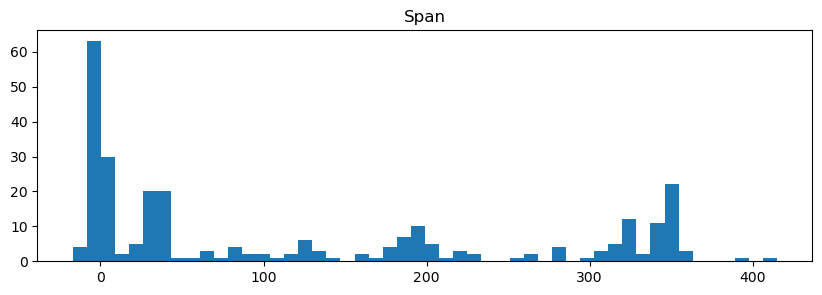

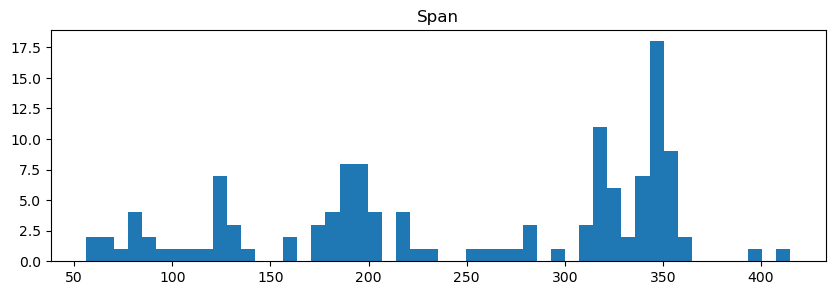

In [11]:
spans = []
for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs():
    spans.append(span)

df = pd.DataFrame({'Span': spans})
df.hist(bins=50, grid=False, figsize=(10,3));
df[df["Span"]>50].hist(bins=50, grid=False, figsize=(10,3));

There's some obvious clusters which represent real matches (eg. around 350 and 320) as well as a smattering of others.

## Find the primer pairs that occur most often per subdir and analyze their spans
For any given primer pair we expect the (distance in the read from start of first primer to end of second) to be consistent from read to read in true matches, but possibly more variable for mispriming.  

In [12]:
from collections import defaultdict
import statistics

perSubdirPrimer = defaultdict(lambda:{"count":0, "spans":[], "mrs":[]})
totalPairs = 0
likelyPairs = 0
goodPairs = 0

for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs():
    totalPairs += 1
    if (span > 50):
        row = perSubdirPrimer[(subdir, pairname)]
        row["spans"].append(span)
        row["mrs"].append(hit1.mr)
        row["mrs"].append(hit2.mr)

known_good_subdir_pairs = set()
table = {"Subdir":[], "PrimerPair":[], "Count":[], "SpanMedian":[], "SpanSD":[], "MRMedian":[]}
for ((subdir, primerpair),row) in perSubdirPrimer.items():
    count = len(row["spans"])
    if count > 1:
        likelyPairs += count
        table["Subdir"].append(subdir)
        table["PrimerPair"].append(primerpair)
        table["Count"].append(count)
        spans = row["spans"]
        table["SpanMedian"].append(round(statistics.median(spans)))
        table["SpanSD"].append(round(statistics.pstdev(spans)))
        table["MRMedian"].append(round(statistics.median(row["mrs"]), ndigits=2))
    if count > 3:
        goodPairs += count
        known_good_subdir_pairs.add((subdir, primerpair))

print("Showing %d of %d possible pairs (%d%%), with %d known good" % 
      (likelyPairs, totalPairs, int(100*likelyPairs/totalPairs), goodPairs))
df = pd.DataFrame(data=table)
df.set_index(["Subdir","PrimerPair"], inplace=True)
df.sort_values("Count", ascending=False, inplace=True)
df

Showing 75 of 274 possible pairs (27%), with 57 known good


Count  SpanMedian  SpanSD  MRMedian
Subdir    PrimerPair                                                     
barcode08 SARS coronavirus 1/2 5/6       14         320       4      0.97
barcode03 Rhinovirus/Enterovirus 1/3     11         344      12      0.97
barcode07 Rhinovirus/Enterovirus 1/3     11         350       6      0.90
barcode06 Rhinovirus/Enterovirus 1/3      9         347       4      0.90
          Rhinovirus/Enterovirus 2/3      8         345       9      0.90
barcode08 SARS coronavirus 1/2 3/4        4         220       7      0.97
barcode01 Human adenovirus 8/13           3         186       3      1.00
barcode03 SARS coronavirus 1/2 2/6        3         133      20      1.00
          Influenza A virus 2/13          2         126       0      0.95
barcode05 Human adenovirus 8/13           2         178       6      0.91
          Human adenovirus 8/9            2         257      64      0.89
barcode06 Human adenovirus 6/9            2         192       2      1.00
          Influenza A virus 2/13          2         201       0      0.89
          Influenza A virus 2/7           2         280       2      1.00

Here we see the true hits (already known from independent sequence alignment): 
 * barcode 8: SARS-CoV-2  (~320bp and ~220bp peaks above)
 * barocde 3, 6 and 7: Rhinovirus (~350bp peak above, expected ~353)
 
Note that the spans for likely matches have a low standard deviation.

## Are the AdV matches in barcode01 real?

In [13]:
def hitString(hit):
    return "%s%s [%d,%d] (%.2f)" % (hit.primer.description, " (rev)" if hit.rev else "", hit.start, hit.end, hit.mr)

for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs("barcode01"):
    if (pairname=="Human adenovirus 8/13"):
        print(">" + hitString(hit1) + " - " + hitString(hit2))
        print("  " + read.seq[hit1.start:hit2.end])

>Human adenovirus 8 [67,83] (0.88) - Human adenovirus 13 (rev) [265,281] (0.82)
  GCAGTGCGGAGTAGGGAAAGGGAAAGCAGAGCGTGGGACTGTCCCTCTGTGCTGGAAGAGGGCTAACACAGCCCCGACTCTCCGCTCTGGCTGAGCCGAGGGGCCTCTCGCCTCCCTCTGTGTTGCCCTAGGGCTCGGTGACCTCTGTCATAGCACTGACCACATGCTATCCTGCCTGTGCCTTCTCTAGCTGTCCCGCCCTGCTCGGAACCGC
>Human adenovirus 13 [193,210] (1.00) - Human adenovirus 8 (rev) [397,414] (1.00)
  GCGGTTCCGGAGTAGGGCGGGGGACAGCTAGAGGAAGGCACAGGCAGGATACCATGTGGTCAGTGCTATGACAGGGTCACCGAGCCCTAGGGCAGCACAGAGGGACAGGGCCCCCTTGGCCTAGCCAGGTGGAGAGTCCGGGCTGGTGTTATGGCCCTCTTCCAGCACAGAGGGAGAGTCCACCCTCTGCTTCTCTTCCCTTTCCCCTACTCCGGCACTGC
>Human adenovirus 13 [64,81] (1.00) - Human adenovirus 8 (rev) [270,287] (1.00)
  GCGGTTCCGGAGTAGGGCAGGGGACAGCTAGAGGAAGGCACAGGCAGGATAGCATGTGGTCCAGTGCTATGACAGAGGTCACCGAGCCCTAGGGCAACACAGAGGACAGAGGGCCCCCTTGGCCTAGCCAGGTGGAGATCCGGGCTGGTGTTAGCCCTCTTCCAGCCACAGAGGGAGAGTCCCACCCTCTGCTTCTCTTCCCTTTCCCCTACTCCGGCACTGC


**No**. [Doing a BLAST](https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastSearch&VIEW_SEARCH=on&UNIQ_SEARCH_NAME=A_SearchOptions_1pOl9S_kyl_dsIGlk8G2B7_GTWlT_NCQp) for this output shows a near perfect match (~one mismatch per primer) to Human Chromosome X. Also the two primers both map to the same position on the minus strand of the Adenovirus genome, so they're not a legit pair. We could exclude these by capturing expected pairings (or at least strand) in the primer input.

## Why are the Rhinovirus reads in barcode06 split?
They're evenly split between the Rhinovirus primer (#1) and Enterovirus D68 primer (#2). Is it possible we have some D68 reads?

In [14]:
printed = 0
for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs("barcode06"):
    if (pairname=="Rhinovirus/Enterovirus 2/3"):
        print(">" + hitString(hit1) + " - " + hitString(hit2) + " len=" + str(len(read)))
        print("  " + read.seq[hit1.end:hit2.start])  # trim primers
        printed += 1
        if printed == 3:
            break

>Rhinovirus/Enterovirus 3 [64,85] (1.00) - Rhinovirus/Enterovirus 2 (rev) [433,452] (0.81) len=478
  TGGTCCCATCCCGCAGTTGCCCGTTACGACTAGCTACACACTGGTTTGCGTGCACTAGCTGCAGGTTTAAGGTTAGCCACATTCAGGGGCCGGAGGACTCAATGCGAGCACGAAGGCTCTTCGCACCTTGTCAAATATACGGCTTCGCACTCAAAGAGTGCGCAGGCAGCCCGCAGGCTAGAACACTGTCGCCAGTGGGGAGCTTCCTAGCCTCATCTGCCAGGTCTACCATGGGAATGGCGGAGCAGCCAACCACATATCATTTCAAGATGATACTAGGCTTTGCGTAGGCACATTGCGGATAACGATCTCAATTGTTTTTGCCCTGGGAGAGCATATCAACTTTGA
>Rhinovirus/Enterovirus 3 [64,85] (1.00) - Rhinovirus/Enterovirus 2 (rev) [411,428] (0.81) len=471
  TGGTCCCATCCCACTGGTGCCGTTACATTCTTCTTTTGGTTTGCATGCACTAGCTGCAGGTTGGGTTAGCCGATTTCAGGGGCCGGAGGACTCAATGTGAGCACGGAATCTTCACCGTAAACCTGCAGCTACTTGCTCAAAGGTGTGAGCCTTTCCTGGCTAGAACACTGTCTCAGCGGTGGGGCTTCTAGCCTCATCTGCCAAGTCCTGTGGGGAATGGCGGAACGACCAACCACATATCATTCCAAGATGATACTAAACTGCGTAGGCACATTGCGGATAACGATCTCAATTTTTTGCCCTGGGAAACATATCAACTTTGATAA
>Rhinovirus/Enterovirus 3 [67,88] (1.00) - Rhinovirus/Enterovirus 2 (rev) [430,450] (0.90) len=504
  TTGGTCCCATCCCGCAGTTGC

A blast search returns Rhinovirus A56, so this is a simple case of mis-priming. It's surprising that the matching primer and mismatching primer are represented at equal frequency.

## What's the cause of the high span deviation in barcode03?

In [15]:
table = {"Read":[], "Len":[], "Span":[]}
for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs("barcode03"):
    if (pairname=="Rhinovirus/Enterovirus 1/3"):
        table["Read"].append(read.id)
        table["Len"].append(len(read))
        table["Span"].append(span)

df = pd.DataFrame(data=table)
df.set_index("Read", inplace=True)
df.sort_values("Span", inplace=True)
df

,Len,Span
Read,,
ced0bdea-73ef-440d-9440-a13702a18140,916,309
ab450ac2-25a8-46c1-aba9-b3256eea9382,504,334
7eca4cf2-4752-47a8-9ce3-a55b7fb468c2,476,338
7f58b3b6-8002-4fa8-869a-3770f20f8b22,500,341
96f7eb6d-9aa6-4927-9d8a-d1aa1bba097d,503,342
5aec69e7-8ec7-4b39-b3f3-c0edcad3eace,504,344
3f464a18-cb4d-4f85-8baa-47f7cc1699b8,506,345
946bd1d5-9c37-4979-9965-1b5c75e3ca73,510,347
e560f5d3-d7d2-447a-bbb2-769053f360d7,533,350


It looks like one read is a real outlier and others are shorter. Let's visualize this with an alignment.

In [16]:
match1 = None
match2 = None
for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs("barcode03"):
    if pairname=="Rhinovirus/Enterovirus 1/3":
        if span==345:
            match1 = read[hit1.end:hit2.start]
        if span==309:
            match2 = read[hit1.end:hit2.start]
print(aligner.align(match1.seq, match2.seq)[0])

target           16 CCACCAGGGCAAAAACAGCTGCGATCGTTATCCGCAAAGCGCCTACGCAAAGCTTAGTAG
                  0 ||...-||||||||||||||||||||||||||||||||.||||||||||||||||.||||
query             1 CCGTG-GGGCAAAAACAGCTGCGATCGTTATCCGCAAAACGCCTACGCAAAGCTTGGTAG

target           76 TACTCTGGAAGTTGTCTGGCTGGTCGCTCCACCATTCCCCTGGTAAGGCCACG--GATGA
                 60 |.|||||-|-||||||-||||||||.-||..---|.||--|||||-|.||..|--|||||
query            60 TGCTCTG-A-GTTGTC-GGCTGGTCA-TCTG---TGCC--TGGTA-GACCTGGCAGATGA

target          134 GGCCT-AAGCTCCCCACTGGCGACAGTGTTCTAGCCTGCGTGGCTGCCTGCACACCCTCT
                120 |||..-||.||||||||||||||||||||||.||||||--|||||||||-|------|--
query           110 GGCTAGAAACTCCCCACTGGCGACAGTGTTCCAGCCTG--TGGCTGCCT-C------T--

target          193 GGGTGTGAAGCCATACAATGGAC----AGGTGTGAAGAGCCCCCGTGTGCTCGCTTT-GA
                180 |||||||||||||||||||||||----||||||||||||||||-|||||||||||||-||
query           159 GGGTGTGAAGCCATACAATGGACTGTGAGGTGTGAAGAGCCCC-GTGTGCTCGCTTTTGA

target          248 GTCC

There's just a number of deletions in the read with a shorter span. 

## Is there any pattern to the sequence data at the start and end of a good read?
Let's start by looking at the distribution of the lengths

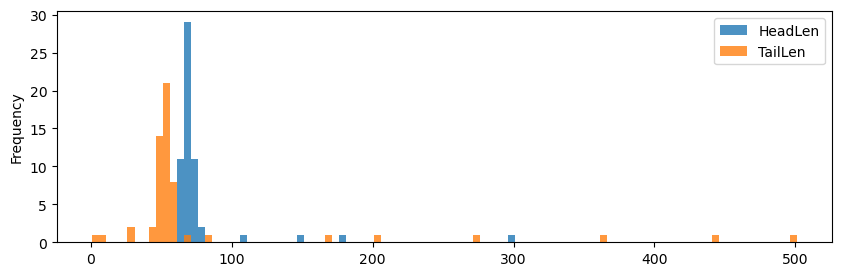

In [17]:
heads = []
tails = []
for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs():
    if (subdir, pairname) in known_good_subdir_pairs:
        heads.append(read.seq[:hit1.start])
        tails.append(read.seq[hit2.end:])

df = pd.DataFrame({'HeadLen': map(lambda seq: len(seq), heads),
                   'TailLen': map(lambda seq: len(seq), tails)})
df.plot.hist(alpha=0.8, bins=100, grid=False, figsize=(10,3));

So the head and tails tend to be pretty specific lengths, but also have some outliers. See if there is any specific sequence that is most common in each.

In [18]:
headCount = Counter()
tailCount = Counter()

for head in heads:
    headCount[str(head)] += 1
for tail in tails:
    tailCount[str(tail)] += 1

print ("Repeat heads: " + str({k:v for (k,v) in headCount.items() if v >1}))
print ("Repeat tails: " + str({k:v for (k,v) in headCount.items() if v >1}))

Repeat heads: {}
Repeat tails: {}


No duplicate sequence. Maybe the heads are the barcodes, let's generate a FASTA file for two of the barcodes for a multiple sequence alignment.

In [19]:
i = 0
for (subdir, read, hit1, hit2, span, pairname) in getPrimerPairs():
    if (subdir, pairname) in known_good_subdir_pairs:
        head = read.seq[:hit1.start]
        if len(head) < 100:
            print (">" + subdir + "h" + str(i))
            print (head)
        tail = read.seq[hit2.end:]
        if len(tail) < 100:
            print (">" + subdir + "t" + str(i))
            print (tail)
        i += 1


>barcode03h0
GCACTCGGTGCTTCGTTCGATTACACGTATTGCTAGGTTAACCTGGTAACTGGGATACAGACTCCAGCACCT
>barcode03t0
AGGTGTGGTGCTTGTCCCAGTTACCAGGTTAACAGCAATACGTAG
>barcode03h1
CAGTGGTGCTTCGTTCAGTTACGTATTTTCTGGCCTGGTAACTGCAGGACTGGGCTAGCACCT
>barcode03h2
GCATGCTTCGTTCAGTTACACGTATTGCTAAGGTTAACCTGGTAACTGGGACACAAGACTTCCAGCACCT
>barcode03t2
GGGTGCTGGAGTCTTGTGTCCCAGTTACCAGGTTAACCTTAGCGTAA
>barcode03h3
TCAGTACTTCGTTCAGTTACGTATTGCTAAGGTTAACCTGGTAACTGGGACACAAGACTCCAGCACCT
>barcode03t3
GAGTGCTGAGTCTTGTGTCCCAGTTACCAGGTTAGCATAGCAATACGTAAC
>barcode03h4
CACATGTACTTCCGTTCAGTTACGTATTGCTAAGGTTAACCTGGTAACTGGGACACAAGACTCCAGCACT
>barcode03t4
GTGCAGGTCTTGTGTCCCAGTTACCAGGTTAACCTTAGCAATACGTGAGAAAGCTTC
>barcode03h5
GGTATGCTTCGTTCAGTTACGTATTGCTAAGGTTAACCTGGTAACTGGGACACAAGACTCCAGCACCT
>barcode03t5
CGAGGGTGCAGGTCTTGTGTCCCAGTTACCAGGTTAACCTTAGCAATACGTAG
>barcode03h6
CGGTATTGCTTCGTTCCAGTTACGTATTGCTAAGGTTAACCTGGTAACTGGAAGCTAGGAACTCCAGCACCT
>barcode03t6
AGGTGCTGGAGTCTTGTGTCAGTTACCAAGGTTAACTATAGCAATACAT
>barcode03h7
CAGTATGCTTCGTTCCAGTT

Loading the above into [Clustal Omega](https://www.ebi.ac.uk/Tools/msa/clustalo/) it's [clear](https://www.ebi.ac.uk/Tools/services/web/toolresult.ebi?jobId=clustalo-I20230211-224533-0470-67694562-p1m) they group by barcode, with all the heads being similar and all the tails being similar. Therefore these are likely include the barcode patterns.

# Debugging

In [20]:
# Dump all the matches for specific known reads for debugging purposes
RCUtils.primer_hits_to_print = 50
for read in getAllReads():
    interestingReads = [
        "c63d9144-0d93-4620-ba79-2a7bf050e813",  # rhinovirus match
        "6129522a-5587-4009-ad7d-e76d677283ab",  # rhinovirus reverse match
        "35e315b6-3dc9-4f51-9974-0be98e9e45d5",  # max overlap
        "b9052c5f-4355-4895-97c8-5297c57cc1c7",  # 7 hits
        "825687be-49e0-4c4b-a950-609181d23d78",  # longest read (1400bp) but with only one hit
    ]
    if read.id in interestingReads:
        print("Read %s len %i" % (read.id,len(read.seq)))
        hits = RCUtils.computePrimerHits(read, primers)
        if len(hits)>0:
            print("Match summary:")
            for hit in hits:
                print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))
                print("    " + read.seq[hit.start:hit.end])
                print("    " + read.seq[hit.start:hit.end].reverse_complement())
            print("")

Read b9052c5f-4355-4895-97c8-5297c57cc1c7 len 288
Match: 0.80 Hendra virus 5 (rev)
target          173 AGCTGCAAAATTTGGCTT 191
                  0 |||||||||-||||||||  18
query             3 AGCTGCAAA-TTTGGCTT  20

Match: 0.86 Human adenovirus 6
target           92 TTGTAAGCAGTGCCAGAGT 111
                  0 |||||||||||||||||||  19
query             0 TTGTAAGCAGTGCCAGAGT  19

Match: 0.96 Human coronavirus 229E 2 (rev)
target          208 GCGGCTCTTAAATCTTTAGGTTTT 232
                  0 ||||||||||||||||||||||||  24
query             0 GCGGCTCTTAAATCTTTAGGTTTT  24

Match: 0.95 Influenza A virus 1
target          124 CTGGTGCACTTGCCAGCTG 143
                  0 ||||||||||||||||.||  19
query             0 CTGGTGCACTTGCCAGTTG  19

Match: 1.00 Influenza A virus 2
target          124 CTGGTGCACTTGCCAGCTG 143
                  0 |||||||||||||||||||  19
query             0 CTGGTGCACTTGCCAGCTG  19

Match: 1.00 Nipah virus 2 (rev)
target          104 CCAGAGTGACCTCAACACCA 124
                  0 |||||